В качестве набора данных мы будем использовать набор данных по определению факта, учится ли человек в колледже
 kaggle.com/datasets/saddamazyazy/go-to-college-dataset?resource=download

Датасет состоит из одного файла:

data.csv
Файл содержит следующие колонки:

type_school - тип школы, которую посещал человек.<br>
school_accreditation - качество школы.<br>
gender - пол.<br>
interest - заинтересованность в посещении колледжа.<br>
parent_age - возраст родителя.<br>
parent_salary - зарплата родителя.<br>
house_area - размер дома.<br>
average_grades - средние оценки.<br>
in_college - учится ли человек в колледже.<br>
В рассматриваемом примере будем решать задачу классификации:<br>

Для решения задачи классификации в качестве целевого признака будем использовать "in_college". Поскольку признак содержит только значения 0 и 1, то это задача бинарной классификации.

# Импорт библиотек

In [57]:
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
sns.set(style="ticks")

# Загрузка данных

In [2]:
original_data = pd.read_csv('data.csv')
data = original_data.drop_duplicates()

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [3]:
data.shape

(1000, 11)

In [4]:
data.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  in_college             1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 80.1+ KB


In [6]:
oe = OrdinalEncoder()

data[['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college',
      'in_college']] = oe.fit_transform(
    data[['type_school', 'school_accreditation', 'gender', 'interest', 'residence', 'parent_was_in_college',
          'in_college']])

In [7]:
data.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,0.0,0.0,1.0,0.0,1.0,56,6950000,83.0,84.09,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,57,4410000,76.8,86.91,0.0,1.0
2,0.0,1.0,0.0,4.0,1.0,50,6500000,80.6,87.43,0.0,1.0
3,1.0,1.0,1.0,4.0,0.0,49,6600000,78.2,82.12,1.0,1.0
4,0.0,0.0,0.0,4.0,1.0,57,5250000,75.1,86.79,0.0,0.0


# Построение графиков

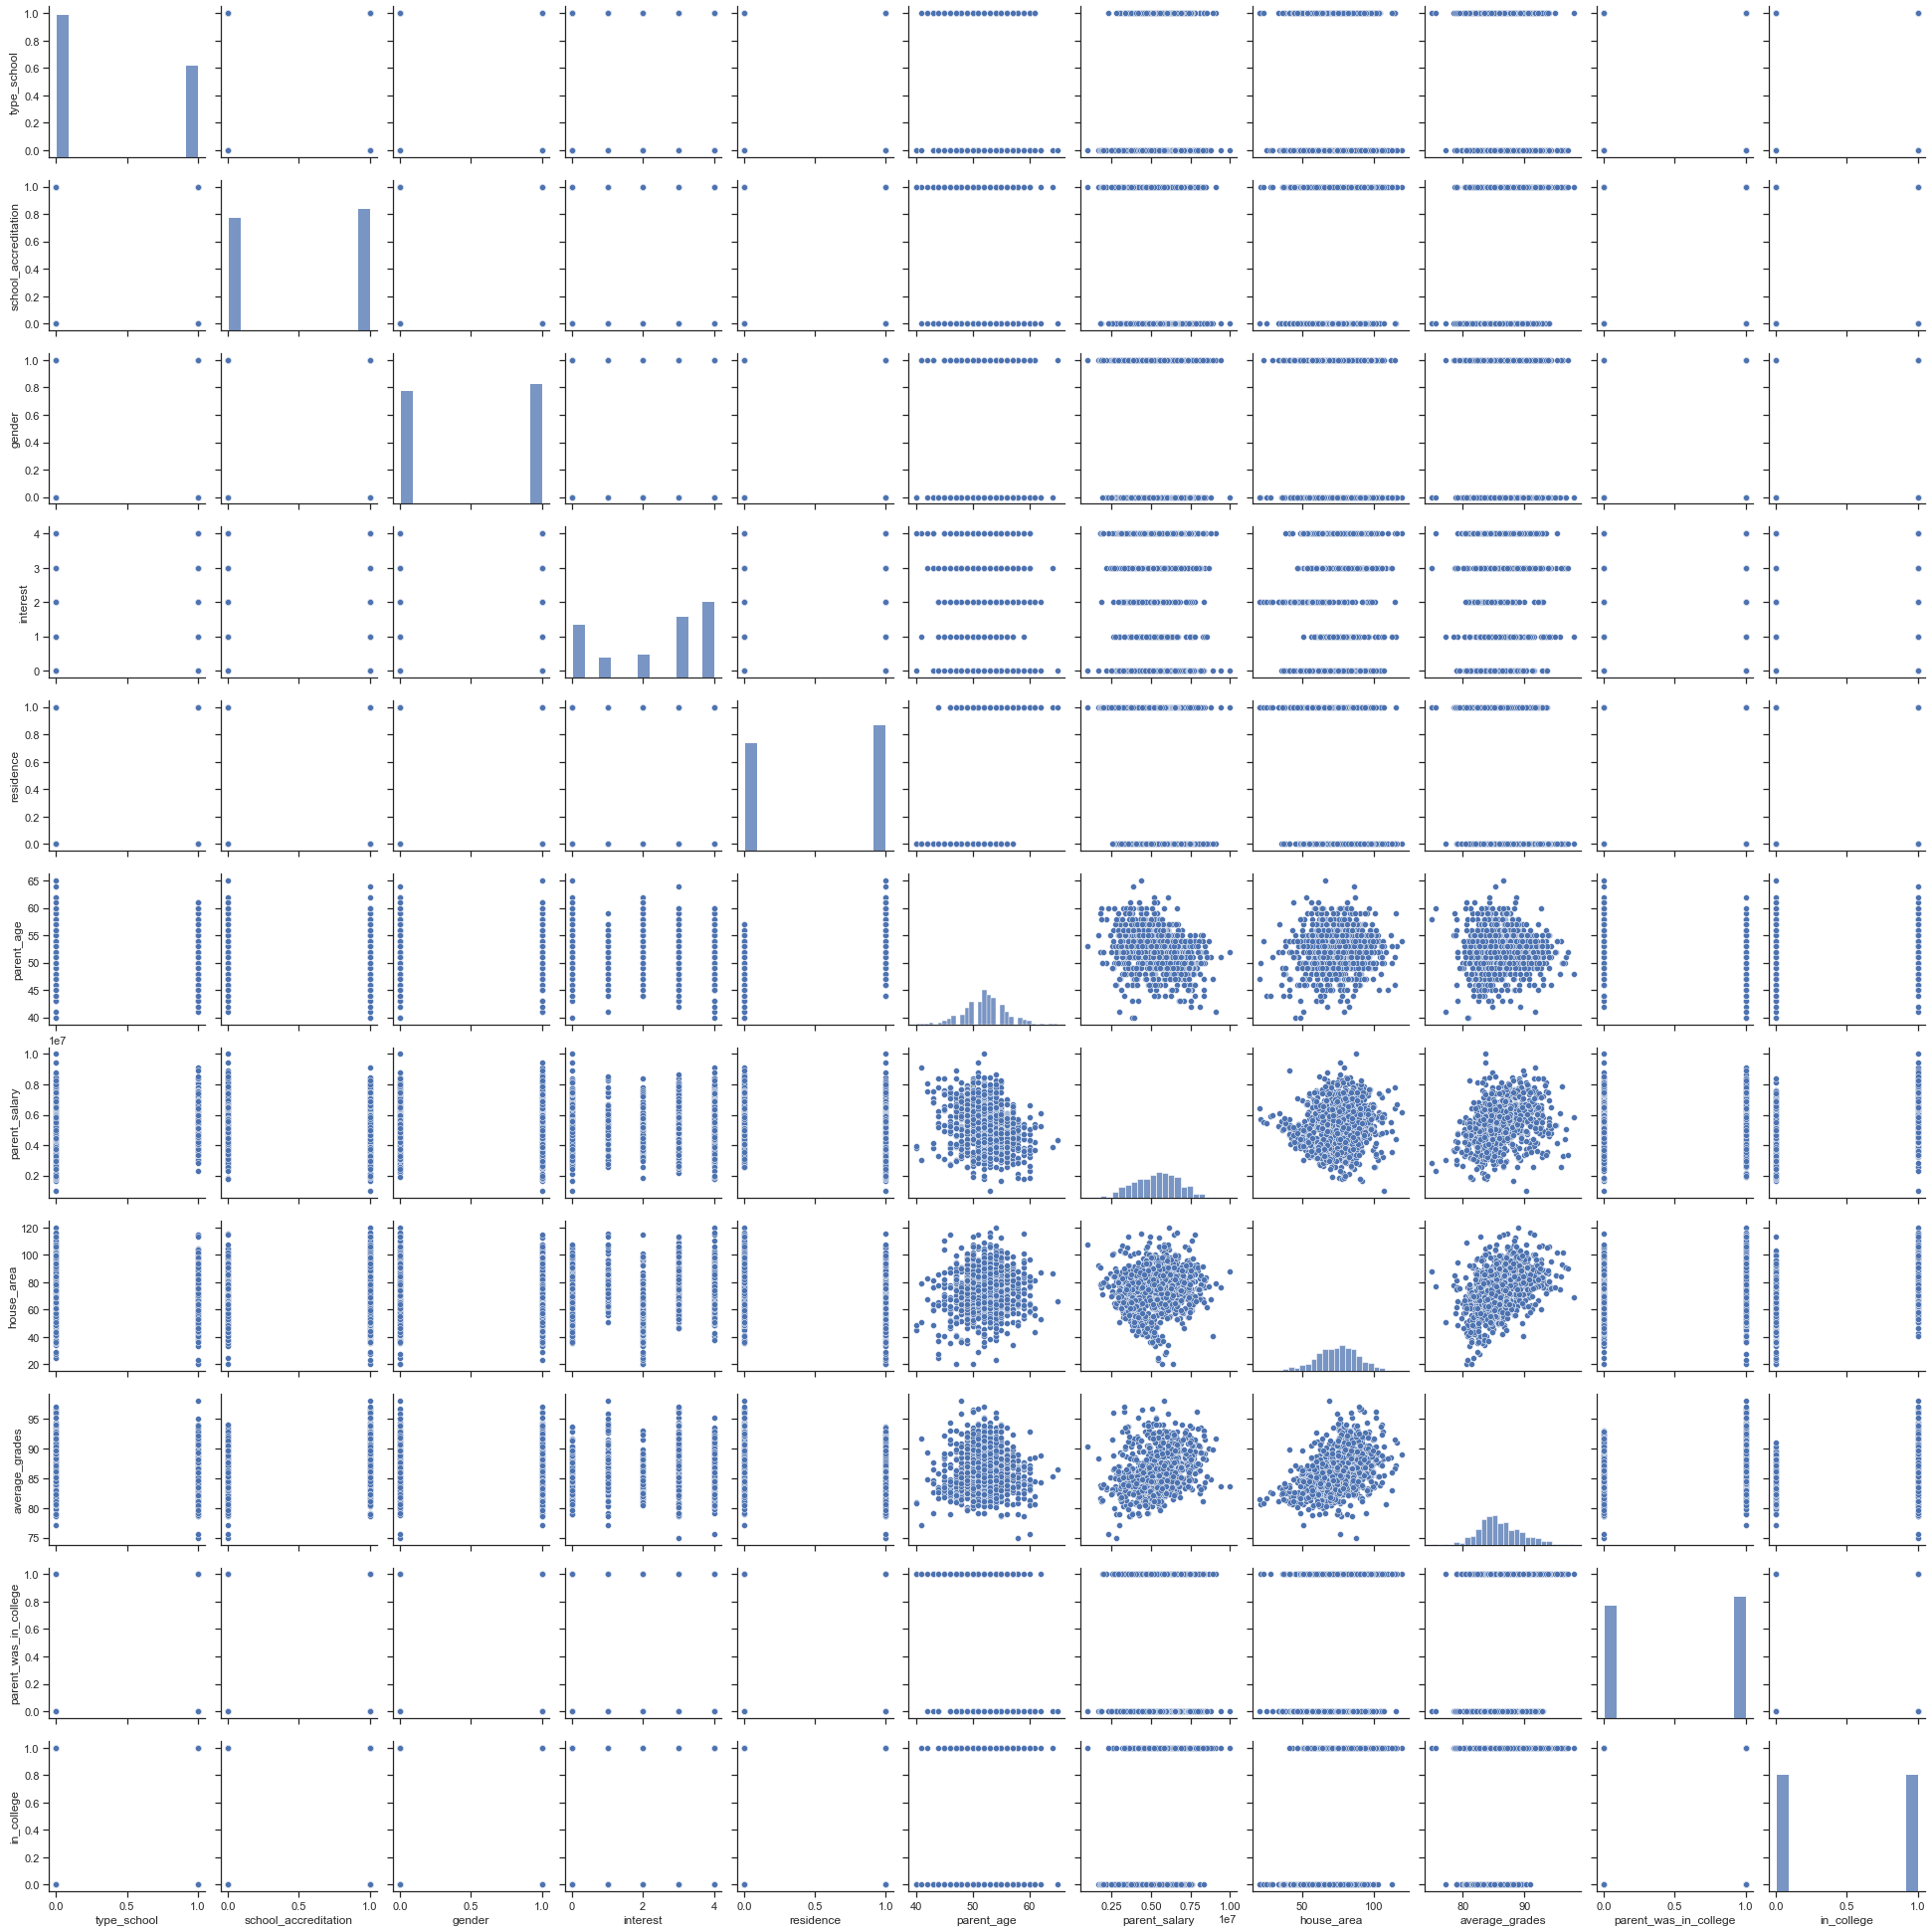

In [8]:
sns.pairplot(data)

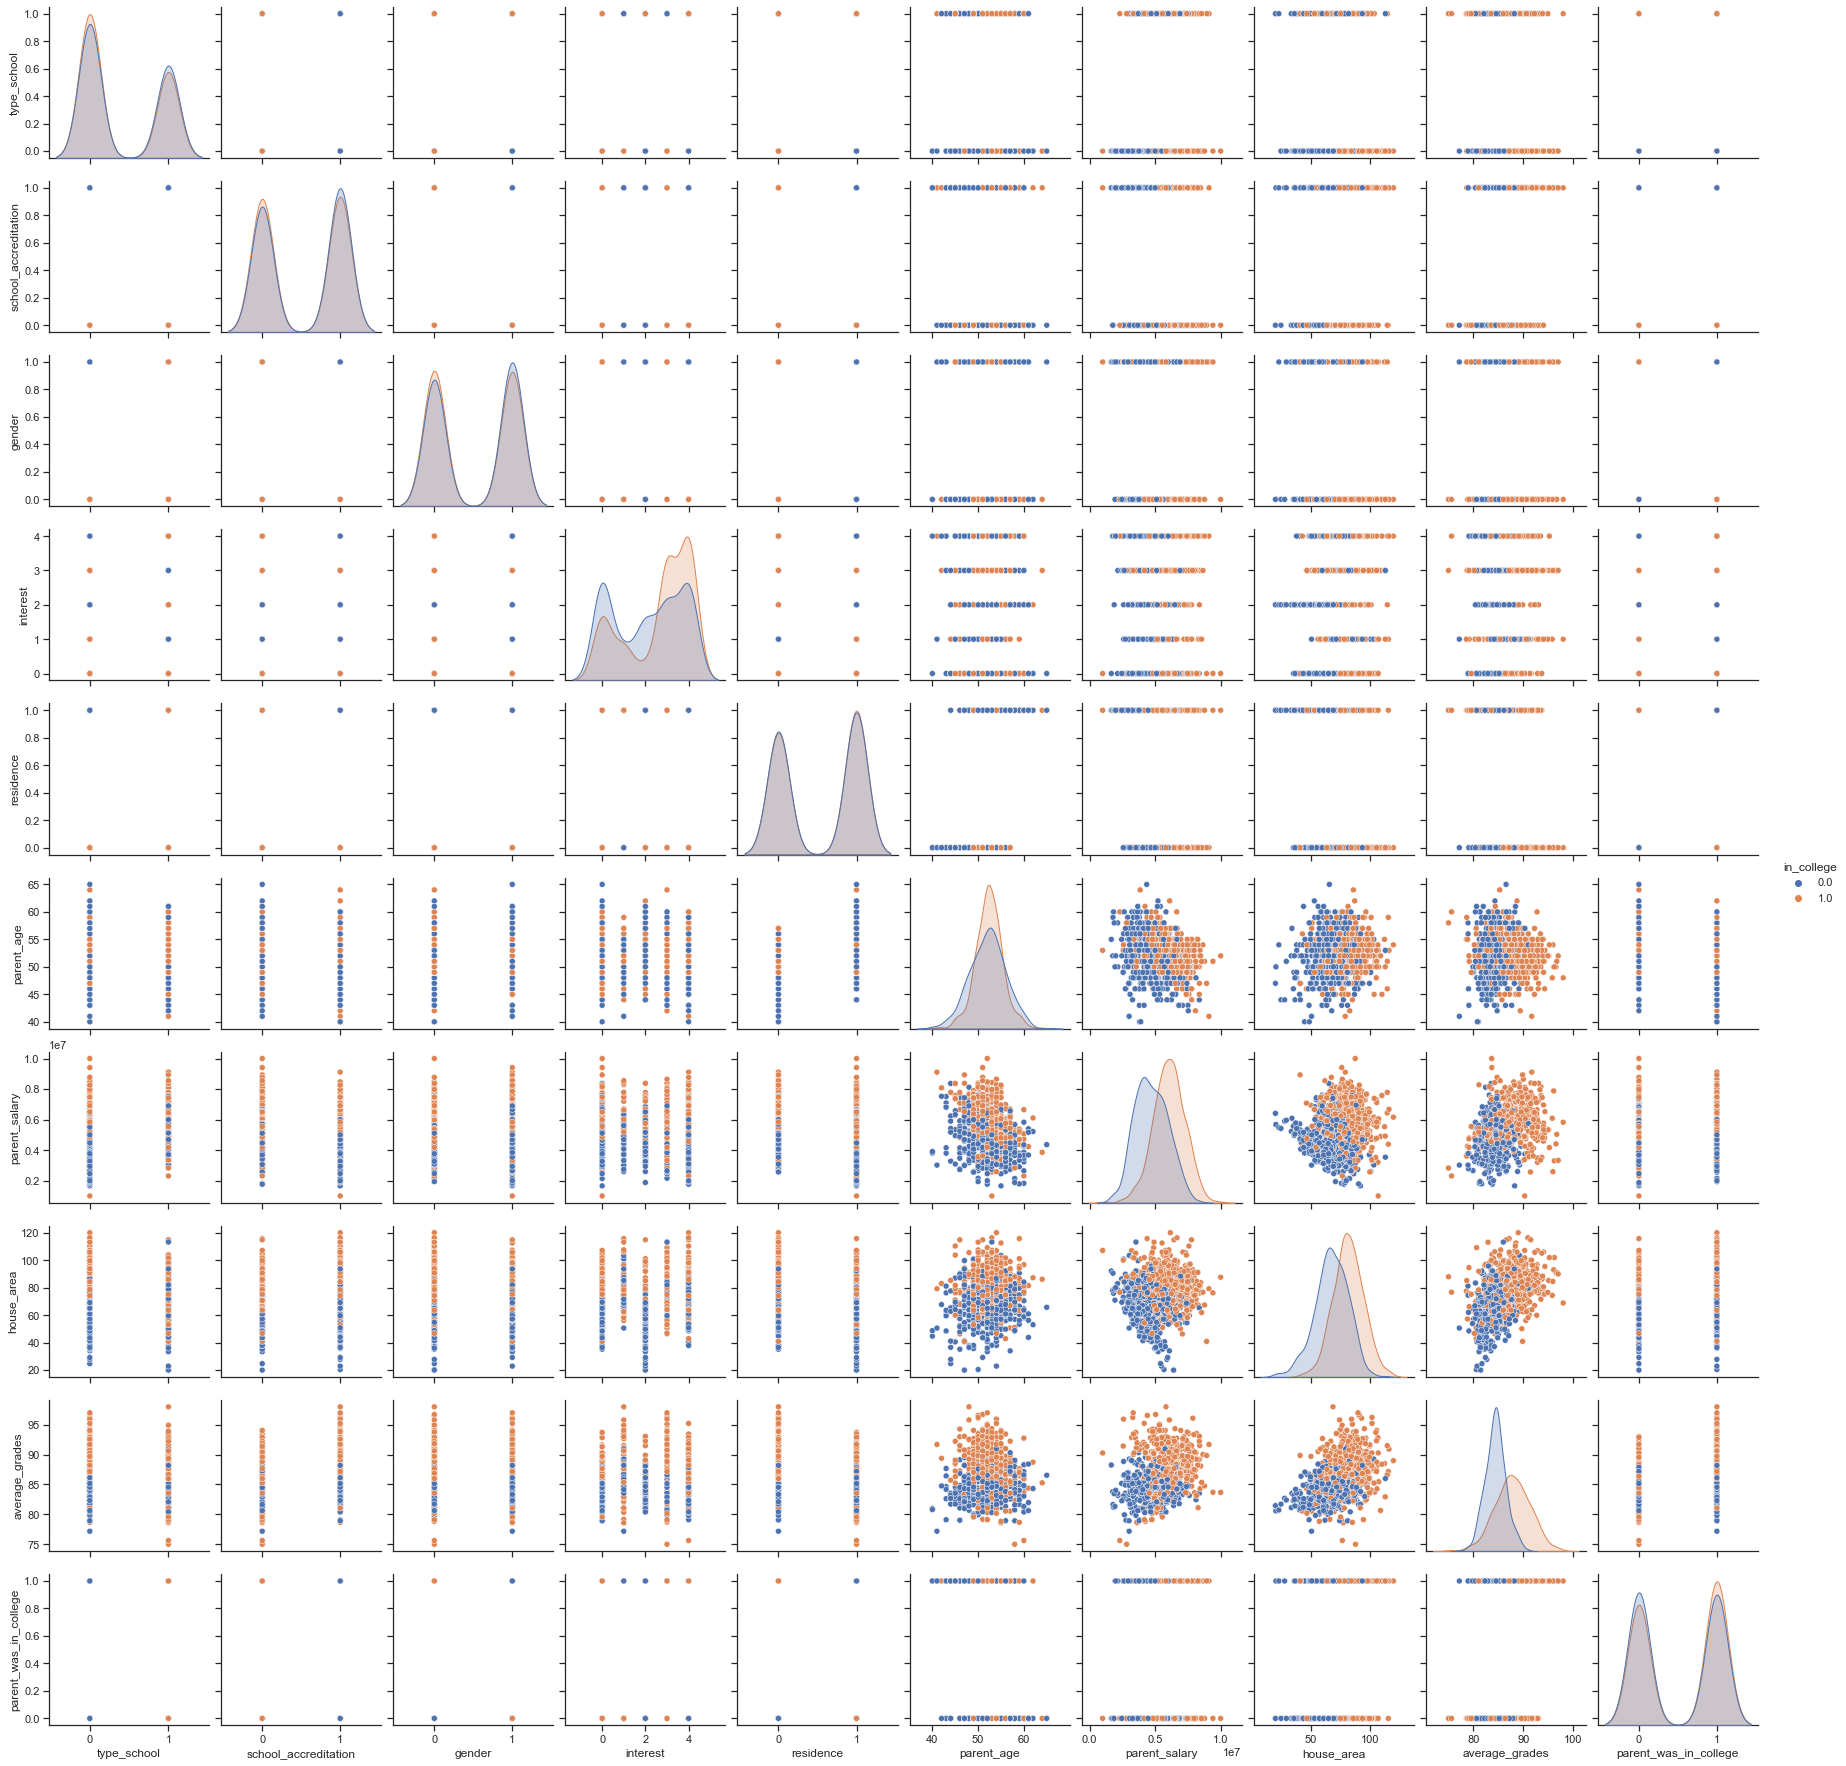

In [9]:
sns.pairplot(data, hue="in_college")

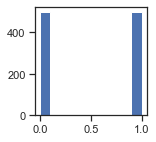

In [10]:
fig, ax = plt.subplots(figsize=(2, 2))
plt.hist(data['in_college'])
plt.show()

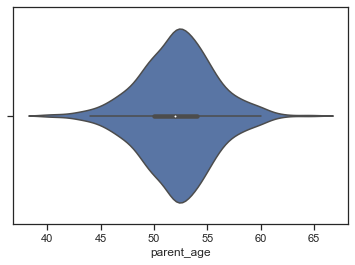

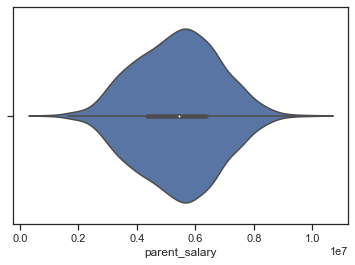

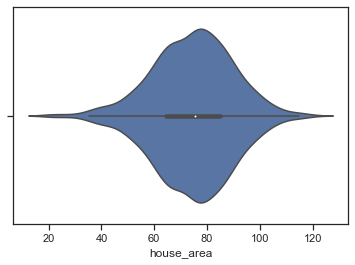

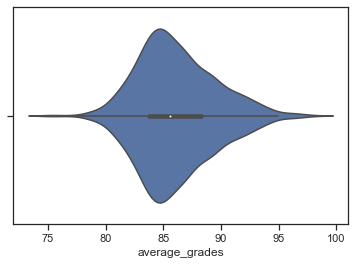

In [11]:
for col in ['parent_age', 'parent_salary', 'house_area', 'average_grades']:
    sns.violinplot(x=data[col])
    plt.show()

## Выбор признаков, подходящих для построения моделей. Масштабирование данных.

In [12]:
scale_cols = ['parent_age', 'parent_salary', 'house_area', 'average_grades', 'interest']

data_unscaled = data.copy()

sc1 = MinMaxScaler()
data[scale_cols] = sc1.fit_transform(data[scale_cols])

data.describe()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000
mean,0.391000,0.519000,0.515000,0.591250,0.539000,0.488320,0.486841,0.545153,0.482487,0.52000,0.50000
std,0.488219,0.499889,0.500025,0.389567,0.498726,0.140017,0.155283,0.152933,0.146902,0.49985,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.250000,0.000000,0.400000,0.373333,0.446000,0.379891,0.00000,0.00000
50%,0.000000,1.000000,1.000000,0.750000,1.000000,0.480000,0.493333,0.555000,0.459783,1.00000,0.50000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.560000,0.598056,0.648250,0.576630,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [13]:
data_unscaled.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,0.0,0.0,1.0,0.0,1.0,56,6950000,83.0,84.09,0.0,1.0
1,0.0,0.0,1.0,0.0,1.0,57,4410000,76.8,86.91,0.0,1.0
2,0.0,1.0,0.0,4.0,1.0,50,6500000,80.6,87.43,0.0,1.0
3,1.0,1.0,1.0,4.0,0.0,49,6600000,78.2,82.12,1.0,1.0
4,0.0,0.0,0.0,4.0,1.0,57,5250000,75.1,86.79,0.0,0.0


## Проведение корреляционного анализа данных.

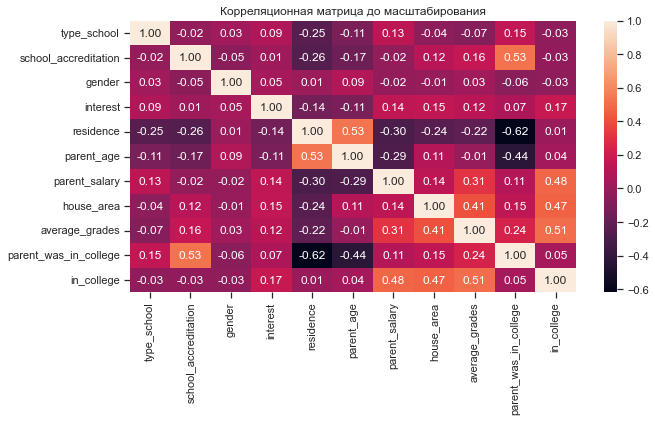

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(data_unscaled.corr(), annot=True, fmt='.2f')
ax.set_title('Корреляционная матрица до масштабирования')
plt.show()

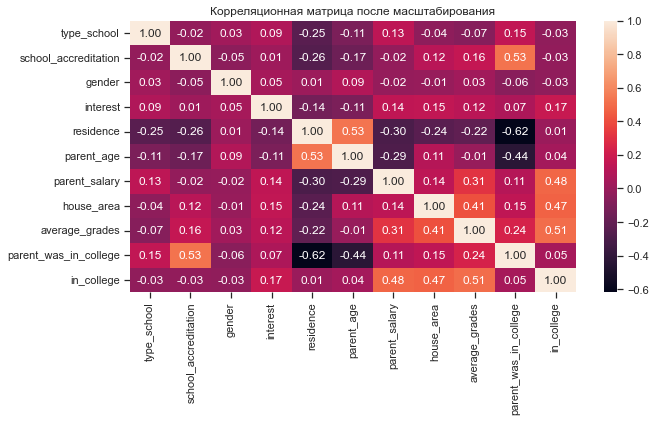

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
ax.set_title('Корреляционная матрица после масштабирования')
plt.show()

## Сохранение и визуализация метрик

In [16]:
class MetricLogger:

    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
             'alg': pd.Series([], dtype='str'),
             'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric'] == metric) & (self.df['alg'] == alg)].index, inplace=True)
        # Добавление нового значения
        temp = [{'metric': metric, 'alg': alg, 'value': value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric'] == metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values

    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5,
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a, b in zip(pos, array_metric):
            plt.text(0.5, a - 0.05, str(round(b, 3)), color='white')
        plt.show()

# Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [17]:
x = data.drop(columns=['in_college'])
y = data['in_college']
x_train: pd.DataFrame
x_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

# Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

In [18]:
clas_models = {'LogR': LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'SVC': SVC(probability=True),
               'Tree': DecisionTreeClassifier(),
               'RF': RandomForestClassifier(),
               'Extra Trees': ExtraTreesClassifier(),
               'GB': GradientBoostingClassifier()}

In [19]:
clasMetricLogger = MetricLogger()

In [20]:
def draw_roc_curve(y_true, y_score, ax, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score,
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    #plt.figure()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_xlim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")

In [21]:
def clas_train_model(model_name, model, clasMetricLogger):
    model.fit(x_train, y_train)
    # Предсказание значений
    y_pred = model.predict(x_test)
    # Предсказание вероятности класса "1" для roc auc
    y_pred_proba_temp = model.predict_proba(x_test)
    y_pred_proba = y_pred_proba_temp[:, 1]

    precision = precision_score(y_test.values, y_pred)
    recall = recall_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred)
    roc_auc = roc_auc_score(y_test.values, y_pred_proba)

    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)
    clasMetricLogger.add('roc_auc', model_name, roc_auc)

    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    draw_roc_curve(y_test.values, y_pred_proba, ax[0])
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[1], display_labels=['0', '1'], cmap=plt.cm.Blues,
                                            normalize='true')
    fig.suptitle(model_name)
    plt.show()

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

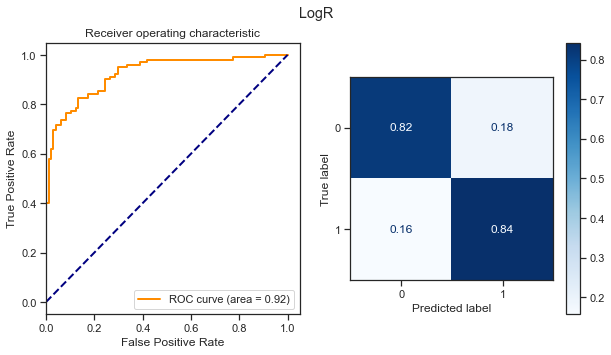

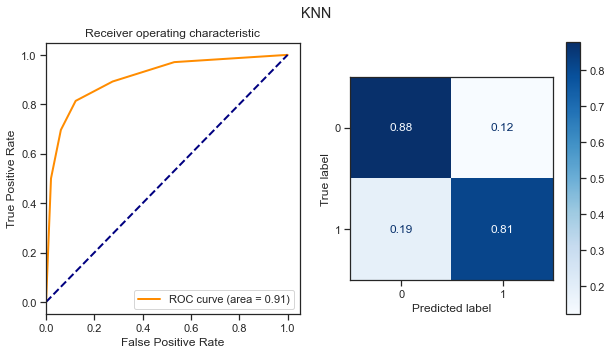

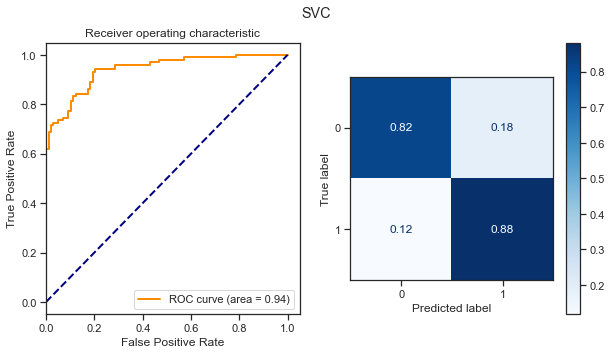

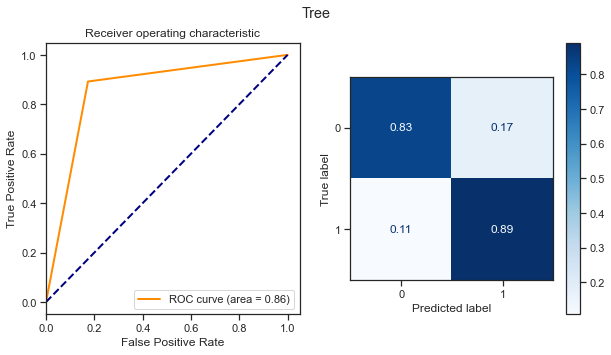

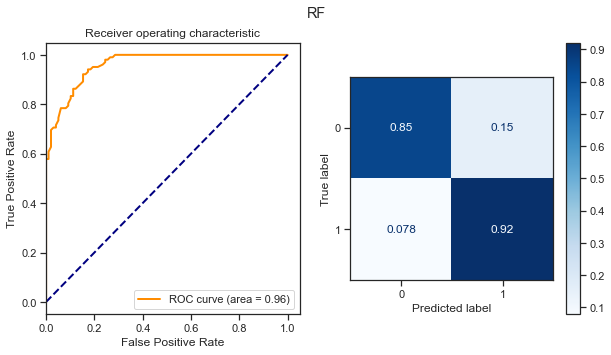

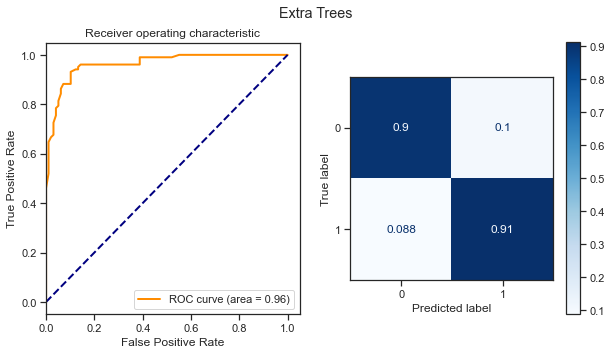

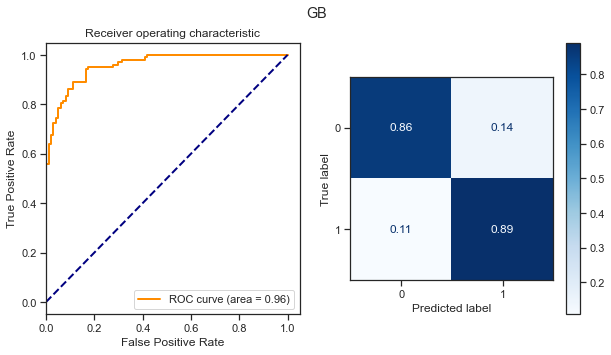

In [22]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

In [45]:
def plot_feature_importances(feature_names, tree_model):
    """
    Функция визуализации важности признаков

    :param feature_names: Названия признаков
    :param tree_model: Модель
    """
    feature_importance_list = list(zip(feature_names, tree_model.feature_importances_))
    sorted_list = sorted(feature_importance_list, key=itemgetter(1), reverse=True)
    feature_order = [x for x, _ in sorted_list]

    plt.figure(figsize=(9,6))
    bar_plot = sns.barplot(x=feature_names, y=tree_model.feature_importances_,
                           order=feature_order)
    bar_plot.bar_label(bar_plot.containers[-1], fmt='%.3f')
    plt.show()

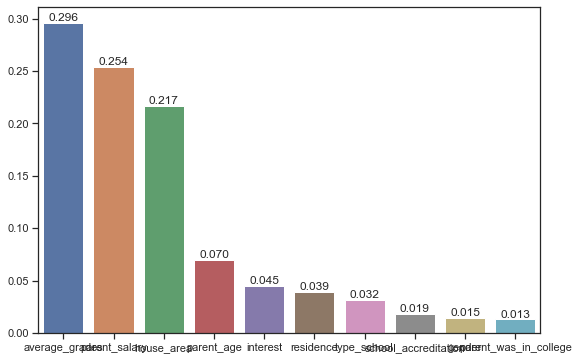

In [46]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)
plot_feature_importances(x.columns.values, rf_classifier)

## Подбор гиперпараметров для выбранных моделей.

In [23]:
n_range_list = list(range(0, 10, 1))
n_range_list[0] = 1

n_range = np.array(n_range_list)
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([1, 1, 2, 3, 4, 5, 6, 7, 8, 9])}]

In [24]:
% % time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
clf_gs.fit(x_train, y_train)

Wall time: 260 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([1, 1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             scoring='roc_auc')

In [25]:
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [26]:
clf_gs.best_params_

{'n_neighbors': 3}

In [27]:
clf_gs_best_params_txt = str(clf_gs.best_params_['n_neighbors'])
clf_gs_best_params_txt

'3'

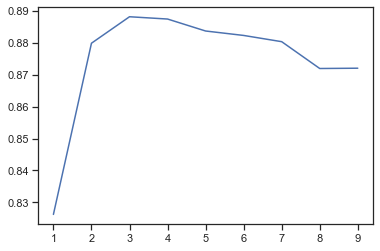

In [28]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [ ]:
def print_compared_metrics(models):
    for model_name, model in clas_models_grid.items():
        clas_train_model(model_name, model, clasMetricLogger)

In [51]:
clas_models_grid = {'KNN': KNeighborsClassifier(n_neighbors=5),
                    str('KNN_' + clf_gs_best_params_txt): clf_gs.best_estimator_}

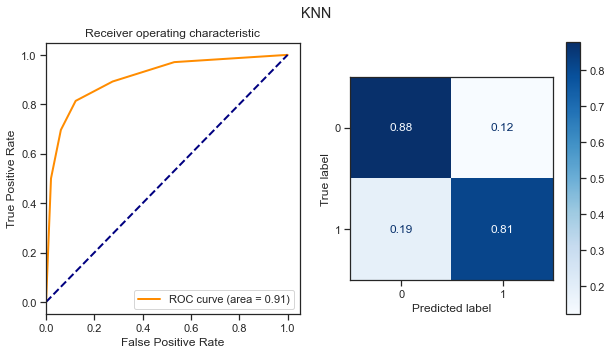

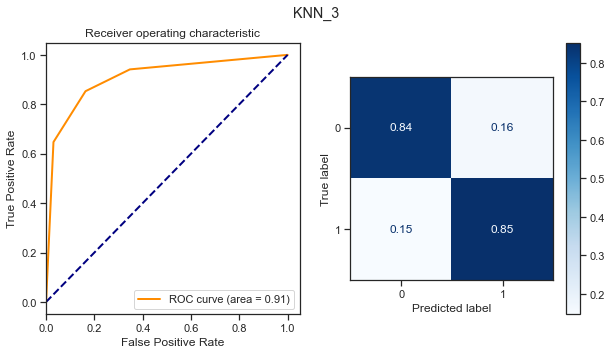

In [52]:
print_compared_metrics(clas_models_grid)

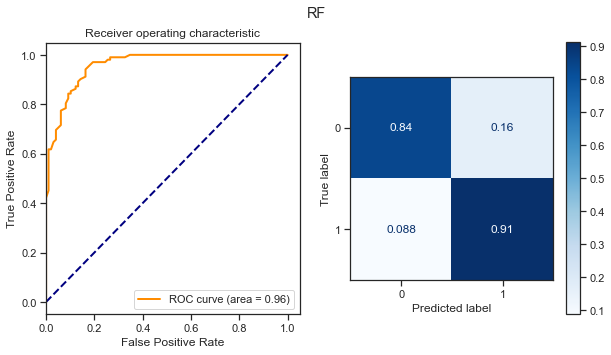

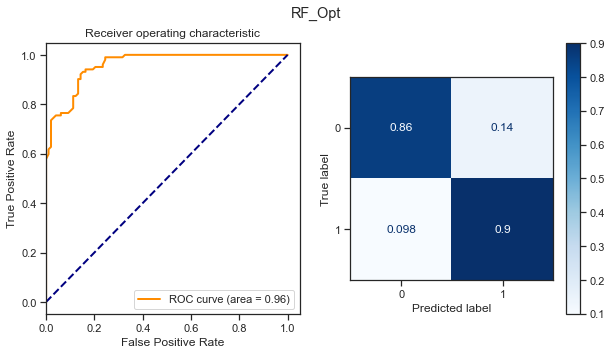

In [61]:
tuned_params = {'max_depth' : range(2,20, 2), 'n_estimators' : range(50,200, 20), 'min_samples_split': range(2, 5)}
rf_gs = RandomizedSearchCV(RandomForestClassifier(), tuned_params, cv=5, scoring='roc_auc')
rf_gs.fit(x_train, y_train)

clas_models_grid = {'RF': RandomForestClassifier(),
                    'RF_Opt': rf_gs.best_estimator_}

print_compared_metrics(clas_models_grid)

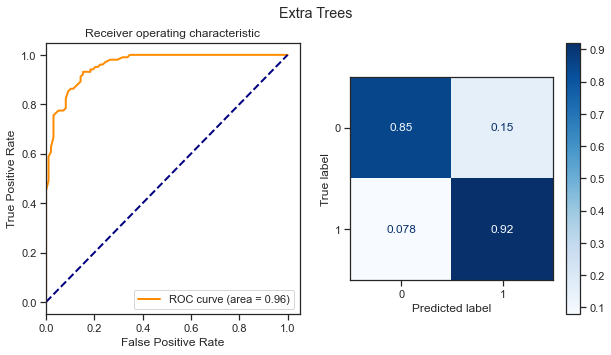

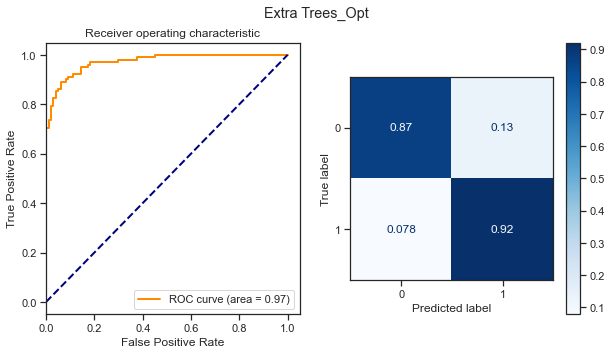

In [60]:
tuned_params = {'max_depth' : range(2,20, 2), 'n_estimators' : range(50,200, 20), 'min_samples_split': range(2, 5)}
rf_gs = RandomizedSearchCV(ExtraTreesClassifier(), tuned_params, cv=5, scoring='roc_auc')
rf_gs.fit(x_train, y_train)

clas_models_grid = {'Extra Trees': RandomForestClassifier(),
                    'Extra Trees_Opt': rf_gs.best_estimator_}

print_compared_metrics(clas_models_grid)

In [31]:
gb_parameters_to_tune = {'loss': ['log_loss', 'deviance', 'exponential'],
                         'learning_rate': np.linspace(0.1, 0.5, 5),
                         'n_estimators': np.arange(10, 51, 10),
                         'max_depth': [3, 4, 5]}

gb_gs = GridSearchCV(GradientBoostingClassifier(random_state=7), gb_parameters_to_tune,
                     cv=5, scoring='roc_auc')
gb_gs.fit(x_train, y_train)

C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
375 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
375 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "C:\Users\Xiaomi\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueErr

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=7),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                         'loss': ['log_loss', 'deviance', 'exponential'],
                         'max_depth': [3, 4, 5],
                         'n_estimators': array([10, 20, 30, 40, 50])},
             scoring='roc_auc')

In [32]:
gb_gs.best_params_

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 50}

In [33]:
gb_gs.best_score_

0.9586218647444913

In [34]:
clas_models_grid = {'GB': GradientBoostingClassifier(),
                    'GB_Opt': gb_gs.best_estimator_}

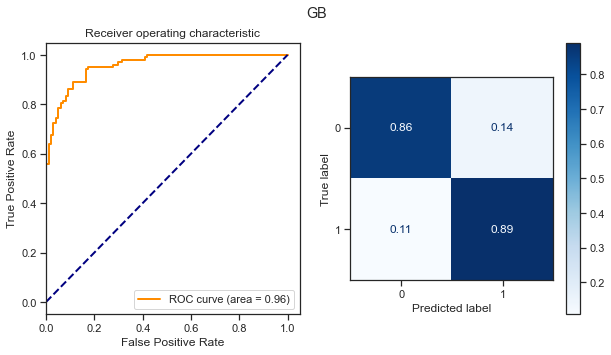

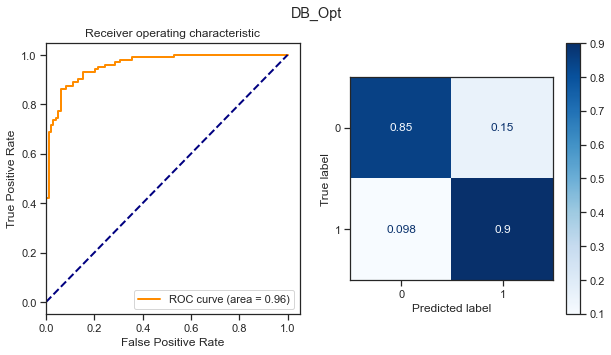

In [50]:
print_compared_metrics(clas_models_grid)

In [36]:
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

array(['precision', 'recall', 'f1', 'roc_auc'], dtype=object)

## Сравнение качества полученных моделей с качеством baseline-моделей.¶

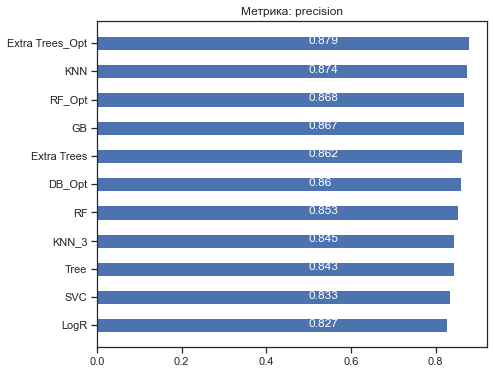

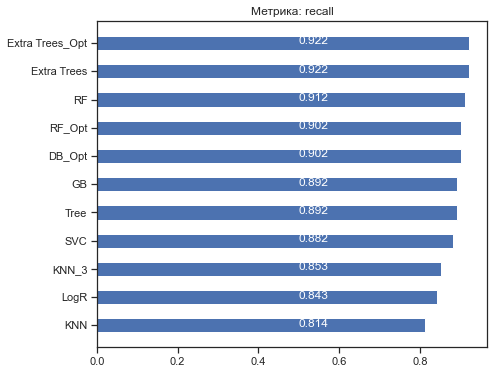

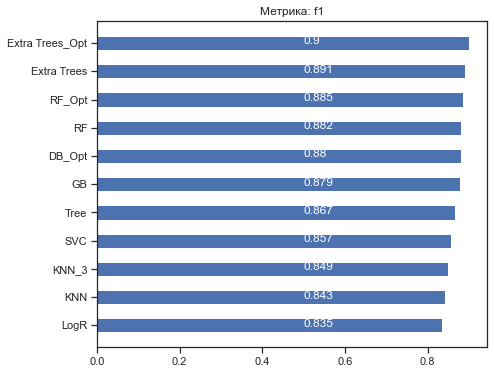

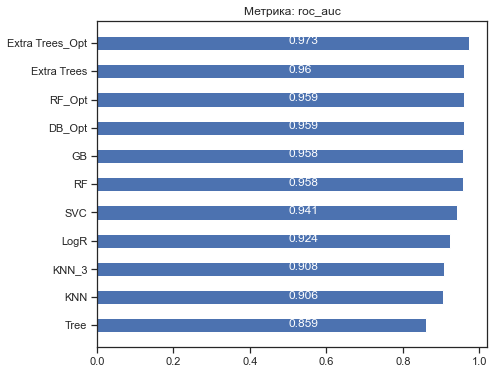

In [62]:
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))